In [1]:
# Import OS libraries
import os
import itertools

# Data handling tools
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report


# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,  BatchNormalization, Activation, Dropout  
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")


# Check GPU availability
print("GPU is available" if tf.config.list_physical_devices('GPU') else "GPU is not available")

sns.set_style('whitegrid')

GPU is available


In [2]:
# Specify the path to the dataset
train_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Training"

# Initialize lists to store file paths and labels
data = []


# Loop through each class folder
for tumor_type in os.listdir(train_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(train_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
train = pd.DataFrame(data, columns=['image_path', 'label'])

train.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Training...,pituitary


In [3]:
# Specify the path to the dataset
test_brain_tumor_mri_dataset = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Initialize lists to store file paths and labels
data = []

# Loop through each class folder
for tumor_type in os.listdir(test_brain_tumor_mri_dataset):
    tumor_type_path = os.path.join(test_brain_tumor_mri_dataset, tumor_type)
    
    # Loop through each image in the class folder
    for filename in os.listdir(tumor_type_path):
        img_path = os.path.join(tumor_type_path, filename)
        
        # Assign label based on folder name
        label = tumor_type
        
        # Append data tuple (image path, label) to the list
        data.append((img_path, label))

# Create a DataFrame from the list
test = pd.DataFrame(data, columns=['image_path', 'label'])

test.head()

,image_path,label
0,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
1,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
2,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
3,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary
4,/kaggle/input/brain-tumor-mri-dataset/Testing/...,pituitary


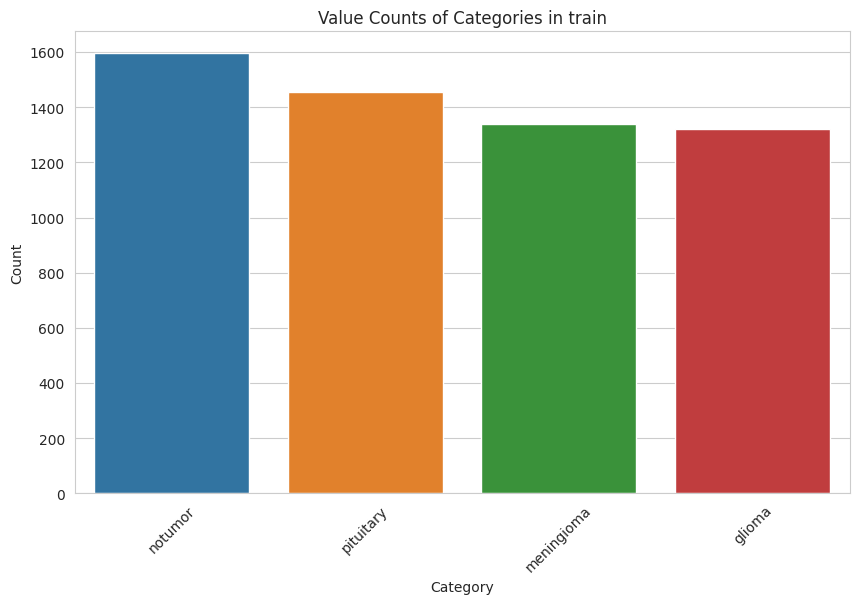

In [4]:
value_counts = train['label'].value_counts()

# Convert the Series to a DataFrame for easier plotting
value_counts_df = value_counts.reset_index()
value_counts_df.columns = ['Category', 'Count']

# Plot using seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x='Category', y='Count', data=value_counts_df)
plt.xticks(rotation=45)
plt.title('Value Counts of Categories in train')
plt.show()

In [5]:
from sklearn.model_selection import train_test_split

# Assuming 'train' and 'test' are your dataframes and 'train' contains a 'label' column
train_data, valid_data = train_test_split(train, test_size=0.2, random_state=42, shuffle=True, stratify=train['label'])

# Display the shape of the resulting sets
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {valid_data.shape}")
print(f"Testing set shape: {test.shape}")


Training set shape: (4569, 2)
Validation set shape: (1143, 2)
Testing set shape: (1311, 2)


In [6]:
from imblearn.under_sampling import RandomUnderSampler

X_train = train_data.drop(columns=['label'])
y_train = train_data['label']

rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_resample(X_train, y_train)

train_data = pd.concat([X_resampled, y_resampled], axis=1)

train_data['label'].value_counts()


label
glioma        1057
meningioma    1057
notumor       1057
pituitary     1057
Name: count, dtype: int64

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Create an ImageDataGenerator for training data with data augmentation
train_datagen = ImageDataGenerator(rescale=1./255)

# Assuming you want to use the same rescaling for validation and test data but without further augmentation
valid_test_datagen = ImageDataGenerator(rescale=1./255)

# Specify the input size expected by the model
input_size = (224, 224)

# Create data generators for training, validation, and testing
train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=True,
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

valid_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=valid_data,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=True,
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)

test_generator = valid_test_datagen.flow_from_dataframe(
    dataframe=test,
    x_col='image_path',
    y_col='label',
    target_size=input_size,
    shuffle=False,
    batch_size=16,
    class_mode='categorical',
    color_mode='rgb'
)


Found 4228 validated image filenames belonging to 4 classes.
Found 1143 validated image filenames belonging to 4 classes.
Found 1311 validated image filenames belonging to 4 classes.


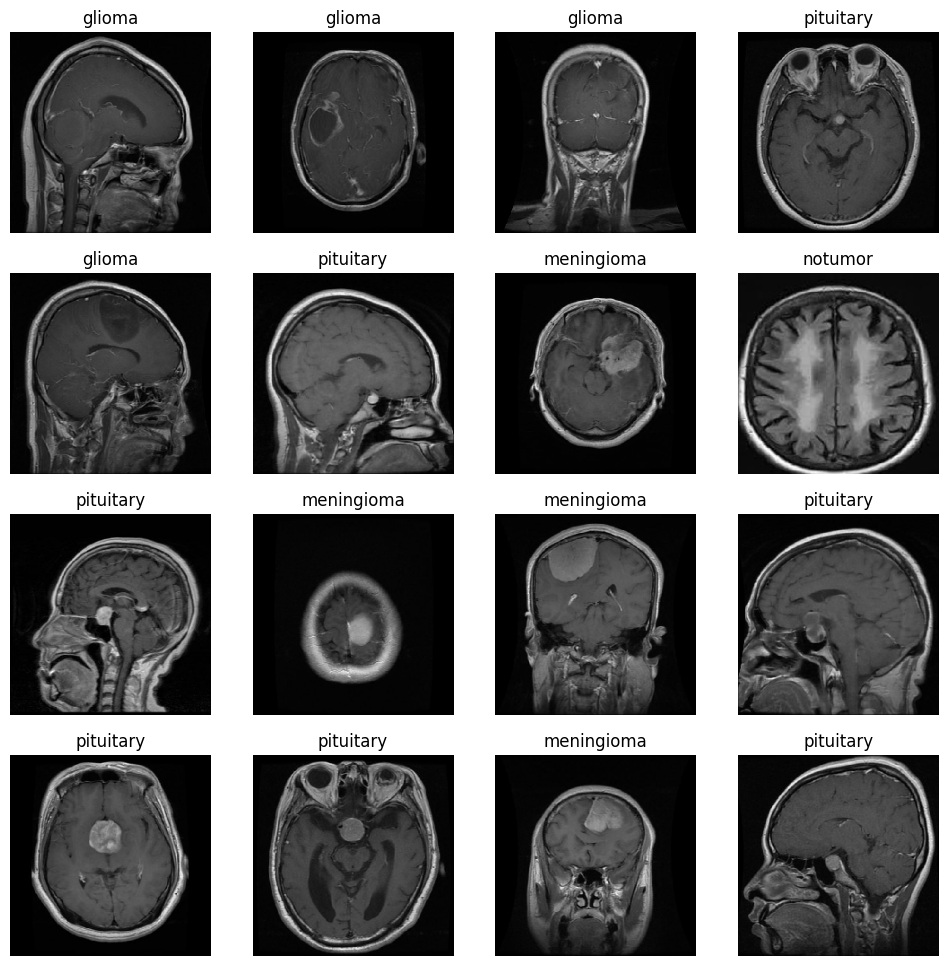

In [8]:
sample_images, sample_labels = next(train_generator)

# Display the images and labels
plt.figure(figsize=(12, 12))
for i in range(16):
    image = sample_images[i]
    label_index = np.argmax(sample_labels[i]) 
    label = list(train_generator.class_indices.keys())[label_index]  

    plt.subplot(4, 4, i+1)
    plt.imshow(image)
    plt.title(label, color='k', fontsize=12)
    plt.axis("off")

plt.show()

In [9]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, concatenate, AveragePooling2D, GlobalAveragePooling2D, Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.regularizers import l2

# Dense Block
def dense_block(x, blocks, growth_rate, name):
    for i in range(blocks):
        x = conv_block(x, growth_rate, name=name + '_block' + str(i + 1))
    return x

# Convolution Block
def conv_block(x, growth_rate, name):
    x1 = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_bn')(x)
    x1 = Activation('relu', name=name + '_relu')(x1)
    x1 = Conv2D(4 * growth_rate, (1, 1), use_bias=False, name=name + '_conv1')(x1)
    x1 = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_bn1')(x1)
    x1 = Activation('relu', name=name + '_relu1')(x1)
    x1 = Conv2D(growth_rate, (3, 3), padding='same', use_bias=False, name=name + '_conv2')(x1)
    x = concatenate([x, x1], axis=-1, name=name + '_concat')
    return x

# Transition Layer
def transition_block(x, reduction, name):
    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name=name + '_bn')(x)
    x = Activation('relu', name=name + '_relu')(x)
    x = Conv2D(int(x.shape[-1] * reduction), (1, 1), use_bias=False, name=name + '_conv')(x)
    x = AveragePooling2D((2, 2), strides=(2, 2), name=name + '_pool')(x)
    return x

# DenseNet Model
def build_densenet(input_shape=(224, 224, 3), num_classes=4, blocks=[6, 12, 24, 16], growth_rate=32, reduction=0.5, weight_decay=1e-4):
    input_layer = Input(shape=input_shape)
    
    # Initial Conv Layer
    x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', use_bias=False, name='conv1_conv')(input_layer)
    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name='conv1_bn')(x)
    x = Activation('relu', name='conv1_relu')(x)
    x = AveragePooling2D((3, 3), strides=(2, 2), padding='same', name='pool1')(x)
    
    # Dense Blocks with Transition Layers
    x = dense_block(x, blocks[0], growth_rate, name='conv2')
    x = transition_block(x, reduction, name='pool2')
    x = dense_block(x, blocks[1], growth_rate, name='conv3')
    x = transition_block(x, reduction, name='pool3')
    x = dense_block(x, blocks[2], growth_rate, name='conv4')
    x = transition_block(x, reduction, name='pool4')
    x = dense_block(x, blocks[3], growth_rate, name='conv5')
    
    # Final Layers
    x = BatchNormalization(axis=-1, epsilon=1.001e-5, name='bn')(x)
    x = Activation('relu', name='relu')(x)
    x = GlobalAveragePooling2D(name='avg_pool')(x)
    
    output_layer = Dense(num_classes, activation='softmax', name='fc')(x)
    
    model = Model(inputs=input_layer, outputs=output_layer, name='densenet')
    return model

# Build DenseNet model
densenet_model = build_densenet(input_shape=(224, 224, 3), num_classes=4)

# Compile the DenseNet model
densenet_model.compile(optimizer=Adamax(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

# Display the model summary
densenet_model.summary()


Model: "densenet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,408 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1               │ (None, 56, 56,    │          0 │ conv1_relu[0][0]  │
│ (AveragePooling2D)  │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_bn     │ (None, 56, 56,    │        256 │ pool1[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_relu   │ (None, 56, 56,    │          0 │ conv2_block1_bn[… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_conv1  │ (None, 56, 56,    │      8,192 │ conv2_block1_rel… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_bn1    │ (None, 56, 56,    │        512 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_relu1  │ (None, 56, 56,    │          0 │ conv2_block1_bn1… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_conv2  │ (None, 56, 56,    │     36,864 │ conv2_block1_rel… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_concat │ (None, 56, 56,    │          0 │ pool1[0][0],      │
│ (Concatenate)       │ 96)               │            │ conv2_block1_con… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_bn     │ (None, 56, 56,    │        384 │ conv2_block1_con… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_relu   │ (None, 56, 56,    │          0 │ conv2_block2_bn[… │
│ (Activation)        │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_conv1  │ (None, 56, 56,    │     12,288 │ conv2_block2_rel… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_bn1    │ (None, 56, 56,    │        512 │ conv2_block2_con… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block2_relu1  │ (None, 56, 56,    │          0 │ conv2_block2_bn1

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [10]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('brain_tumors/best_model.keras', save_best_only=True)

In [11]:
# Replace alexnet_model with googlenet_model for training
history = densenet_model.fit(
    train_generator, 
    epochs=20, 
    validation_data=valid_generator,
    validation_steps=None, 
    shuffle=False,
    callbacks=[early_stopping, model_checkpoint]
)


Epoch 1/20


I0000 00:00:1727477095.142697      94 service.cc:145] XLA service 0x7d448c005510 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727477095.142759      94 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1727477173.813161      94 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


264/265 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step - accuracy: 0.6860 - loss: 0.7877

I0000 00:00:1727477293.146662      96 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_425', 36 bytes spill stores, 36 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_14', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_15', 4 bytes spill stores, 4 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_16', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_17', 12 bytes spill stores, 12 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_reduce_fusion_18', 16 bytes spill stores, 16 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'input_compare_reduce_slice_fusion_1', 640 bytes spill stores, 6

265/265 ━━━━━━━━━━━━━━━━━━━━ 280s 559ms/step - accuracy: 0.6865 - loss: 0.7866 - val_accuracy: 0.2773 - val_loss: 5.5199
Epoch 2/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.8332 - loss: 0.4371 - val_accuracy: 0.3106 - val_loss: 3.5467
Epoch 3/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.8719 - loss: 0.3531 - val_accuracy: 0.6098 - val_loss: 1.3578
Epoch 4/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 129ms/step - accuracy: 0.9005 - loss: 0.2947 - val_accuracy: 0.7997 - val_loss: 0.5593
Epoch 5/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.9169 - loss: 0.2301 - val_accuracy: 0.8609 - val_loss: 0.4073
Epoch 6/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 34s 128ms/step - accuracy: 0.9174 - loss: 0.2290 - val_accuracy: 0.9186 - val_loss: 0.2343
Epoch 7/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 32s 122ms/step - accuracy: 0.9445 - loss: 0.1465 - val_accuracy: 0.9003 - val_loss: 0.2816
Epoch 8/20
265/265 ━━━━━━━━━━━━━━━━━━━━ 33s 123ms/step - accuracy: 0.9634 - loss: 0.1124 - va

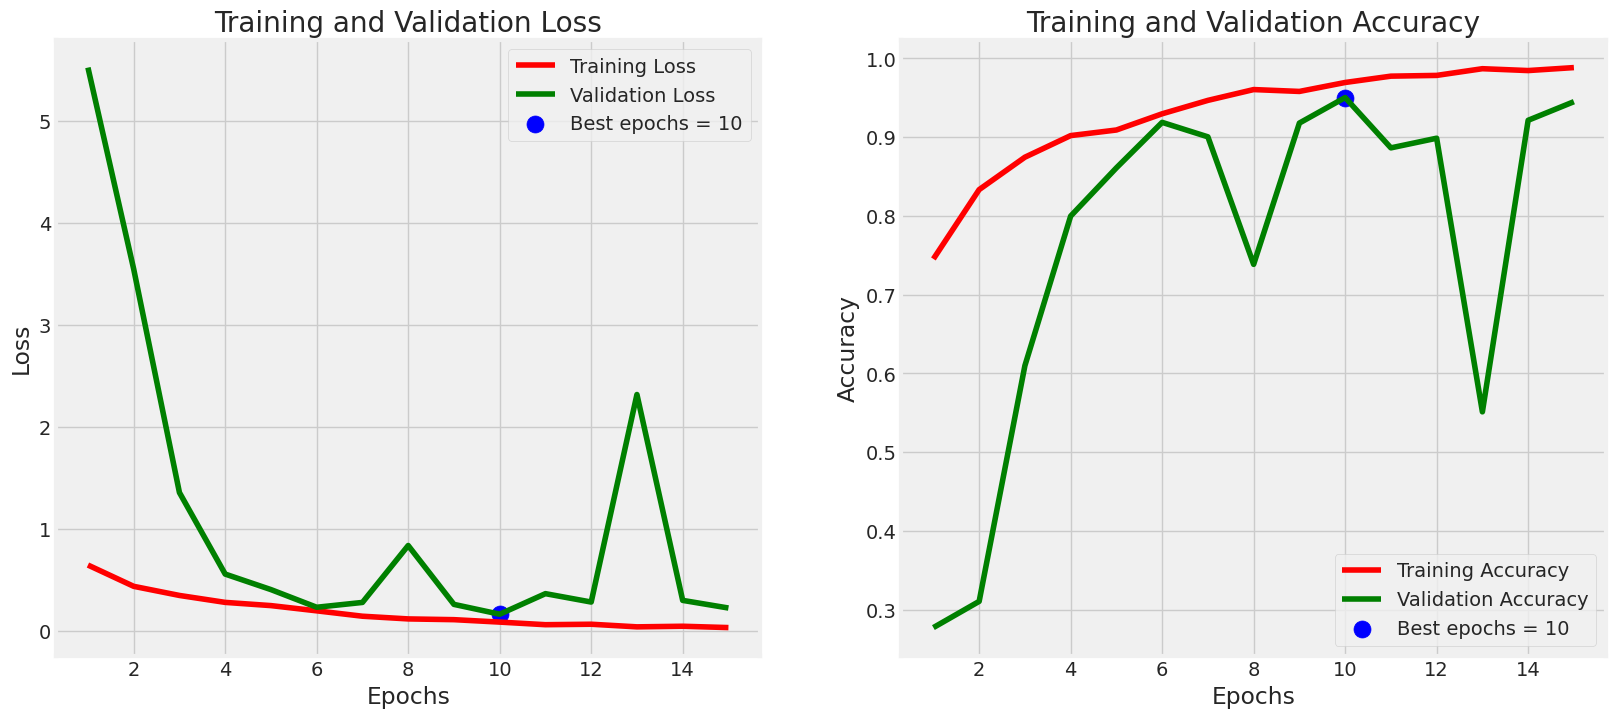

In [12]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

In [13]:
# Evaluate the AlexNet model on the training set
train_score = densenet_model.evaluate(train_generator)
print(f"Training Loss: {train_score[0]}, Training Accuracy: {train_score[1]}")

# Evaluate the AlexNet model on the validation set
valid_score = densenet_model.evaluate(valid_generator)
print(f"Validation Loss: {valid_score[0]}, Validation Accuracy: {valid_score[1]}")

# Evaluate the AlexNet model on the test set
test_score = densenet_model.evaluate(test_generator)
print(f"Test Loss: {test_score[0]}, Test Accuracy: {test_score[1]}")


265/265 ━━━━━━━━━━━━━━━━━━━━ 16s 61ms/step - accuracy: 0.9730 - loss: 0.0763
Training Loss: 0.0707353949546814, Training Accuracy: 0.9744560122489929
72/72 ━━━━━━━━━━━━━━━━━━━━ 3s 44ms/step - accuracy: 0.9532 - loss: 0.1467
Validation Loss: 0.1662108302116394, Validation Accuracy: 0.9501312375068665
82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 227ms/step - accuracy: 0.9702 - loss: 0.0989
Test Loss: 0.18302054703235626, Test Accuracy: 0.9389778971672058


In [14]:
preds = densenet_model.predict(test_generator)

y_pred = np.argmax(preds, axis=1)

82/82 ━━━━━━━━━━━━━━━━━━━━ 18s 130ms/step


[[287   7   0   6]
 [ 18 248  22  18]
 [  3   5 397   0]
 [  0   1   0 299]]


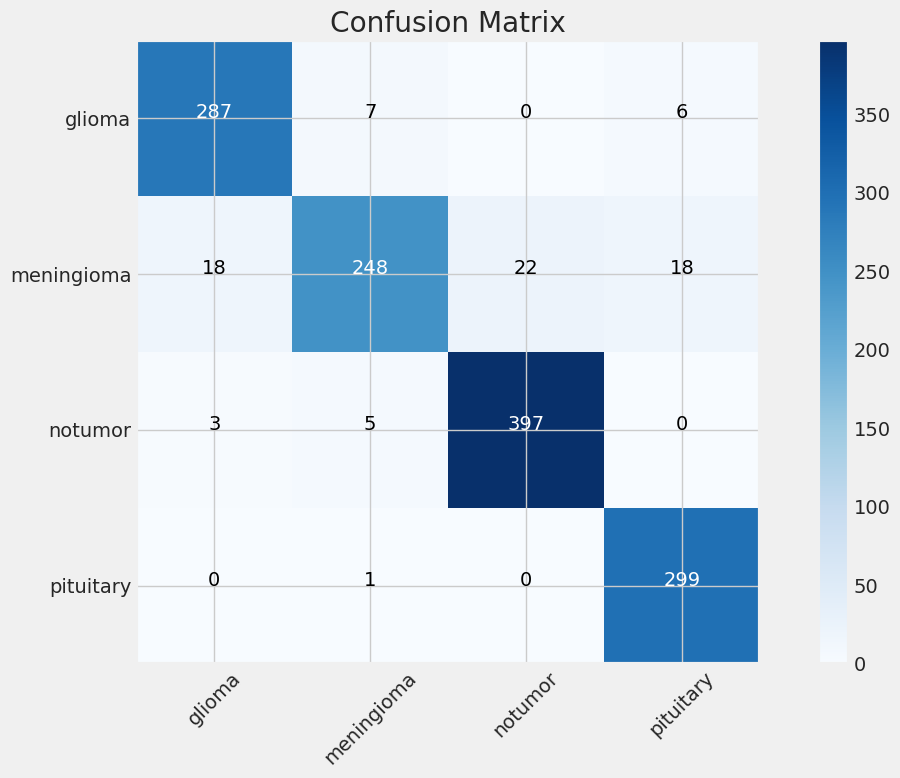

In [15]:
g_dict = test_generator.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)

print(cm)

plt.figure(figsize= (12, 8))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()

plt.show()

In [16]:
print(classification_report(test_generator.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       0.93      0.96      0.94       300
  meningioma       0.95      0.81      0.87       306
     notumor       0.95      0.98      0.96       405
   pituitary       0.93      1.00      0.96       300

    accuracy                           0.94      1311
   macro avg       0.94      0.94      0.94      1311
weighted avg       0.94      0.94      0.94      1311



In [17]:
densenet_model.save('/kaggle/working/bc.keras')